### Car brand classification (Pytorch)

##### Import

In [1]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import copy

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

print ('Current cuda device is', DEVICE)

BATCH_SIZE = 32 
EPOCH = 10 
IMG_SIZE = (160, 160)

Current cuda device is cuda


##### Data load

In [4]:
PATH = 'd:/CarsDataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test_img')

In [5]:
# val_dataset
# val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [800, 13])

In [8]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(IMG_SIZE), 
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(contrast=(0.8, 1)), 
                                transforms.RandomRotation(degrees=(-20, 20)),
                                # transforms.RandomVerticalFlip(),  
                                transforms.ToTensor()]),
                        
    'validation': transforms.Compose([transforms.Resize(IMG_SIZE),
                               transforms.ToTensor()])
}

image_datasets = {x: ImageFolder(root=os.path.join(PATH, x), transform=data_transforms[x]) for x in ['train', 'validation']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'validation']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

class_names = image_datasets['train'].classes
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

In [11]:
# transform_train = transforms.Compose([transforms.Resize(IMG_SIZE),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ColorJitter(contrast=(0.8, 1)),
#                                      transforms.RandomRotation(degrees=(-20, 20)),
#                                      transforms.ToTensor()]) 

# transform_base = transforms.Compose([transforms.Resize(IMG_SIZE),
#                                      transforms.ToTensor()]) 

# train_dataset = ImageFolder(root=train_dir, transform=transform_train) 
# val_dataset = ImageFolder(root=validation_dir, transform=transform_base)
# # ImageFolder : 대용량 이미지 데이터를 데이터셋으로 관리하는 모듈

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [10]:
images, labels = next(iter(dataloaders['train']))
labels
images.shape

torch.Size([32, 3, 160, 160])

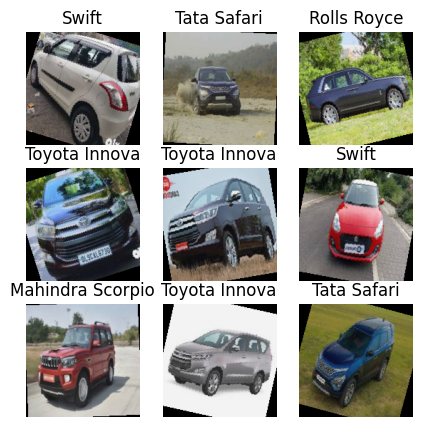

In [12]:
tmp = next(iter(dataloaders['train']))

plt.figure(figsize=(5, 5))
images = tmp[0]
labels = tmp[1]
for i in range(9):  # 9개의 이미지 출력
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)))
    plt.title(class_names[labels[i]])  # images에 해당하는 레이블 출력
    plt.axis("off")

### Transfer learning - ResNet50

In [13]:
from torchvision import models

###################### 전이학습 모델 불러오기
resnet = models.resnet50(pretrained=True)  

c:\Users\user\miniconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\miniconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
###################### fc layer 구조 변경
num_ftrs = resnet.fc.in_features   # resnet.fc 레이어의 입력 개수는 기존 fc 레이어의 in_feature 속성값을 통해 알아냄
resnet.fc = nn.Linear(num_ftrs, 7) # fc를 nn.Linear(num_ftrs, 7)로 대체, resnet의 기본 numclasses는 1000개이므로 내 데이터에 맞춰서 변경함
resnet = resnet.to(DEVICE) # 출력층 확인
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.0001)
 
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

##### Layer 출력물 확인

In [16]:
model_weights = [] # save conv layer weights
conv_layers = [] # save 49 conv layers

model_children = list(resnet.children())

counter = 0 

for i in range(len(model_children)): # resnet50의 모든 층을 확인함
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:  # 블록 bottleneck 내부 레이어에 sequential convolution layer가 포함되는지 확인함
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


In [17]:
for weight, conv in zip(model_weights, conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [18]:
i=0
for name, module in resnet.named_modules():
    print(i, name)
    i+=1
    # if isinstance(module, torch.nn.Sequential):
    #     feature_map = module.output.squeeze()
    #     print(f"Layer {name} feature map shape:", feature_map.shape)

        # 예시로 첫 번째 feature map을 시각화합니다.
        # plt.figure()
        # plt.imshow(feature_map[0].detach().numpy(), cmap="gray")
        # plt.show()

0 
1 conv1
2 bn1
3 relu
4 maxpool
5 layer1
6 layer1.0
7 layer1.0.conv1
8 layer1.0.bn1
9 layer1.0.conv2
10 layer1.0.bn2
11 layer1.0.conv3
12 layer1.0.bn3
13 layer1.0.relu
14 layer1.0.downsample
15 layer1.0.downsample.0
16 layer1.0.downsample.1
17 layer1.1
18 layer1.1.conv1
19 layer1.1.bn1
20 layer1.1.conv2
21 layer1.1.bn2
22 layer1.1.conv3
23 layer1.1.bn3
24 layer1.1.relu
25 layer1.2
26 layer1.2.conv1
27 layer1.2.bn1
28 layer1.2.conv2
29 layer1.2.bn2
30 layer1.2.conv3
31 layer1.2.bn3
32 layer1.2.relu
33 layer2
34 layer2.0
35 layer2.0.conv1
36 layer2.0.bn1
37 layer2.0.conv2
38 layer2.0.bn2
39 layer2.0.conv3
40 layer2.0.bn3
41 layer2.0.relu
42 layer2.0.downsample
43 layer2.0.downsample.0
44 layer2.0.downsample.1
45 layer2.1
46 layer2.1.conv1
47 layer2.1.bn1
48 layer2.1.conv2
49 layer2.1.bn2
50 layer2.1.conv3
51 layer2.1.bn3
52 layer2.1.relu
53 layer2.2
54 layer2.2.conv1
55 layer2.2.bn1
56 layer2.2.conv2
57 layer2.2.bn2
58 layer2.2.conv3
59 layer2.2.bn3
60 layer2.2.relu
61 layer2.3
62 laye

In [27]:
# get_layer_name = [name for name in resnet.named_children()]
# get_layer_name

# ### 층별 파라미터 확인
# i = 0
# for name, child in resnet.named_children():  # named_parameters 가중치 뽑아주는 함수
#     print(i,child)
#     i+=1
#     if isinstance(child, nn.Sequential):
#         for sub_name, sub_child in child.named_children():
#             print(i, sub_child)
#             i+= 1

# ### 층별 파라미터 확인
# i = 0
# for name, child in resnet.named_children():  # named_parameters 가중치 뽑아주는 함수
#     # print(i,child)
#     # i+=1
#     # print(name)
#     if isinstance(child, nn.Sequential):
#         # print(child)
#         print(resnet._modules[name])
#         # for sub_name, sub_child in child.named_children():
#         #     print(i, sub_child)
#         #     i+= 1

In [40]:
from PIL import Image
plt.figure(figsize=(2,2))

file='d:/CarsDataset/test_img/1.jpg'

img=Image.open(file).resize((160,160))
newimg=np.reshape(img, (1,3,160,160))
data=torch.Tensor(newimg)
data=data.to(DEVICE)
data

C:\Users\user\AppData\Local\Temp\ipykernel_12940\1667752440.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  data=torch.Tensor(newimg)


tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [253., 253., 253.,  ...,  34.,  39.,  39.],
          [ 38.,  54.,  54.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 253., 253., 251.]],

         [[251., 251., 253.,  ...,  46.,  48.,  48.],
          [ 46.,  62.,  62.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 251., 251., 251.],
          ...,
          [156., 168., 167.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ...,   4.,   2.,   4.],
          [  4.,   4.,   0.,  ..., 172., 179., 178.]],

         [[184., 204., 203.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ...,  15.,  14.,  28.],
          [ 28.,  27.,  24.,  ..., 197., 221., 220.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ...

<Figure size 200x200 with 0 Axes>

##### Feature Extraction

In [46]:
## 모델의 합성곱층 가중치 고정

# for param in resnet.parameters():
#     param.requires_grad = False

# for param in resnet.fc.parameters():
#     param.requires_grad = True


###################### 전이학습 모델의 일부 layer 동결

ct = 0 
for child in resnet.children():  
    ct += 1  
    if ct < 8: # 4층 이하는 동결시킴 (block1까지만)
        for param in child.parameters():
            param.requires_grad = False


In [47]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['train', 'validation']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0   # 배치마다 손실 및 정확도 누적
            running_corrects = 0  
 
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() # 이전 그래디언트 값 초기화
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  # batch를 모델에 입력해 출력값 계산
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  # 손실 계산
    
                    if phase == 'train':   
                        loss.backward()  # 손실에 대한 gradient 계산
                        optimizer.step()  # 계산된 gradient를 이용해 가중치 업데이트
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            if phase == 'train':  
                scheduler.step()
 
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
 
          
            if phase == 'validation' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    model.load_state_dict(best_model_wts) 

    return model

In [48]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH) 

# torch.save(model_resnet50, 'resnet50.pt')

-------------- epoch 1 ----------------
train Loss: 1.1435 Acc: 0.6339
validation Loss: 1.0958 Acc: 0.6605
Completed in 0m 15s
-------------- epoch 2 ----------------
train Loss: 1.1414 Acc: 0.6399
validation Loss: 1.0943 Acc: 0.6470
Completed in 0m 14s
-------------- epoch 3 ----------------
train Loss: 1.1355 Acc: 0.6399
validation Loss: 1.0893 Acc: 0.6531
Completed in 0m 14s
-------------- epoch 4 ----------------
train Loss: 1.1328 Acc: 0.6366
validation Loss: 1.0871 Acc: 0.6593
Completed in 0m 14s
-------------- epoch 5 ----------------
train Loss: 1.1350 Acc: 0.6396
validation Loss: 1.0845 Acc: 0.6679
Completed in 0m 14s
-------------- epoch 6 ----------------
train Loss: 1.1252 Acc: 0.6465
validation Loss: 1.0822 Acc: 0.6593
Completed in 0m 14s
-------------- epoch 7 ----------------
train Loss: 1.1346 Acc: 0.6423
validation Loss: 1.0869 Acc: 0.6581
Completed in 0m 14s
-------------- epoch 8 ----------------


KeyboardInterrupt: 

##### Evaluate Model

In [ ]:
transform_base = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])
test_base = ImageFolder(root='./splitted/test',transform=transform_base)  
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)